In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

import dyflownet as dfn

In [2]:
num_step = 10000

warm_up, peak_hour = 1000, 5000

demand_mainline = np.zeros(num_step)
demand_mainline[:warm_up] = 0.6
demand_mainline[warm_up:(warm_up+peak_hour)] = 0.9
demand_mainline[(warm_up+peak_hour):] = 0.6

demand_onramp = np.zeros(num_step)
demand_onramp[:warm_up] = 0.2
demand_onramp[warm_up:(warm_up+peak_hour)] = 0.4
demand_onramp[(warm_up+peak_hour):] = 0.2

ratio_offramp = np.zeros(num_step)
ratio_offramp[:warm_up] = 0.05
ratio_offramp[warm_up:(warm_up+peak_hour)] = 0.15
ratio_offramp[(warm_up+peak_hour):] = 0.05

ratio_downstream_mainline = 1 - ratio_offramp

split_ratio = np.vstack([ratio_downstream_mainline, ratio_offramp])[None, :, :]

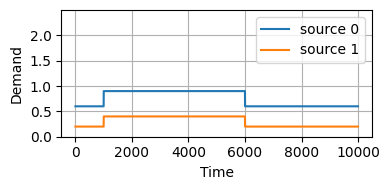

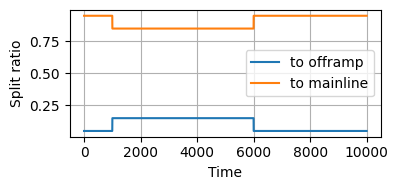

In [3]:
# Plot.
plt.figure(figsize=(4, 2))

plt.plot(demand_mainline, label='source 0')
plt.plot(demand_onramp, label='source 1')
plt.ylim([0, 2.5])
plt.gca().set_yticks([0, 0.5, 1, 1.5, 2])
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Demand')

plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 2))

plt.plot(ratio_offramp, label='to offramp')
plt.plot(ratio_downstream_mainline, label='to mainline')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Split ratio')

plt.tight_layout()
plt.show()

## Freeway-Ramp Junction

source 0 -> sink 0

source 0 -> sink 1

source 1 -> sink 0


In [4]:
def build_net(has_control=False):
    net_0 = dfn.net.Network(ID='net_0', state_len = 1, num_step = 10000, time_step_size = 0.01)

    source_0 = dfn.cell.Source(
        ID = 'source_0', initial_condition = {'density': [0]}, 
        boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=demand_mainline, is_bc_constant=False),
        sending = dfn.flow.BufferSendingFlow(demand=demand_mainline, capacity=1, is_demand_constant=False),
    )
    
    source_1 = dfn.cell.Source(
       ID = 'source_1', initial_condition = {'density': [0]}, 
       boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=demand_onramp, is_bc_constant=False),
       sending = dfn.flow.BufferSendingFlow(demand=demand_onramp, capacity=0.5, is_demand_constant=False),
    )

    sink_0 = dfn.cell.Sink(
        ID = 'sink_0', initial_condition = {'density': [0]}, 
        receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=6, capacity=np.inf),
        boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1),
    )

    sink_1 = dfn.cell.Sink(
        ID = 'sink_1', initial_condition = {'density': [0]}, 
        receiving = dfn.flow.UnboundedReceivingFlow(),
        boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1),
    )

    if has_control:
        ramp_meter = dfn.controller.AffineController(gain=1, max_control_input=2, cell_list=[sink_0])
    else:
        ramp_meter = None

    junction_0 = dfn.node.FreewayRampJunction(
        ID = 'node_0', incoming_cell_list = [source_0, source_1], outgoing_cell_list = [sink_0, sink_1],
        split_ratio = split_ratio, is_split_ratio_constant = False, 
        onramp_priority = [1], controller = ramp_meter, 
    )

    net_0.add_cell('source', source_0)
    net_0.add_cell('source', source_1)
    net_0.add_cell('sink', sink_0)
    net_0.add_cell('sink', sink_1)

    net_0.add_node(junction_0)

    return net_0


def get_TTT(net):
    part_1 = np.sum(net.source_list[0].state_output['density'])
    part_2 = np.sum(net.source_list[1].state_output['density'])
    part_3 = np.sum(net.sink_list[0].state_output['density'])

    return (part_1+part_2+part_3)

In [5]:
net_0 = build_net()
net_0.run()
TTT_no_metering = get_TTT(net_0)


controlled_net_0 = build_net(True)
controlled_net_0.run()
TTT_metering = get_TTT(controlled_net_0)

source_0 initialized.
source_1 initialized.
sink_0 initialized.
sink_1 initialized.
node_0 initialized.
time cost: 1.9 seconds.
source_0 initialized.
source_1 initialized.
sink_0 initialized.
sink_1 initialized.
node_0 initialized.
time cost: 2.0 seconds.


In [6]:
print(TTT_no_metering)

print(TTT_metering)

50420.82039114271
43804.48639862462


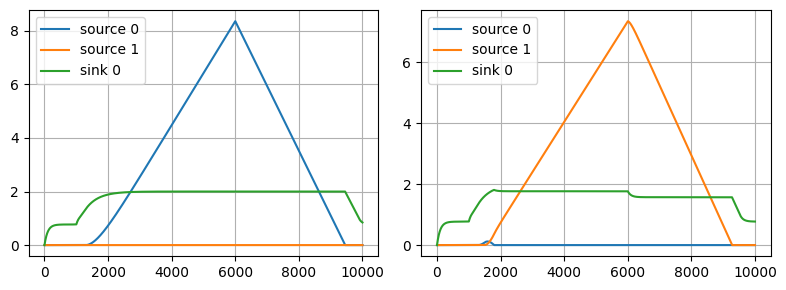

In [7]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(net_0.source_list[0].state_output['density'], label='source 0')
plt.plot(net_0.source_list[1].state_output['density'], label='source 1')
plt.plot(net_0.sink_list[0].state_output['density'], label='sink 0')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(controlled_net_0.source_list[0].state_output['density'], label='source 0')
plt.plot(controlled_net_0.source_list[1].state_output['density'], label='source 1')
plt.plot(controlled_net_0.sink_list[0].state_output['density'], label='sink 0')
plt.legend()
plt.grid()

plt.tight_layout()

plt.show()